# SPAM/HAM CLASSIFICATION

Поля датасета:
- text_type - целевая переменная, флаг
СПАМ/не СПАМ
- text - текст сообщения.
Ответить

Задача:
- провести базовую аналитику по имеющимся данным,
- обучить модель по тексту сообщения определять, является ли ее содержимое
СПАМом (ожидается, что будут опробованы несколько подходов, из которых аргументированно выбирается наилучший; можно использовать любую библиотеку или фреймворк),
- целевой метрикой при оценке работы модели будет ROC-AUC score,
- произвести скоринг лучшей моделью
тестовых данных, а результат записать в csv-файл в виде таблицы с колонками
score n text;
- выложить код на jupyter notebook и результирующий файл со скорами модели на https://github.com отдельным проектом и поделиться ссылкой в поле для ответа.

In [ ]:
import pandas as pd

train_data = pd.read_csv('train_spam.csv')
test_data = pd.read_csv('test_spam.csv')

In [ ]:
train_data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [ ]:
test_data.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


### Подазадача 1: провести базовую аналитику по имеющимся данным

####  Очистка данных


In [ ]:
train_data.isnull().sum()

text_type    0
text         0
dtype: int64

In [ ]:
test_data.isnull().sum()

text    0
dtype: int64

In [ ]:
train_data.shape

(16278, 2)

In [ ]:
test_data.shape

(4070, 1)

In [ ]:
train_data['text_type'].unique()

array(['ham', 'spam'], dtype=object)

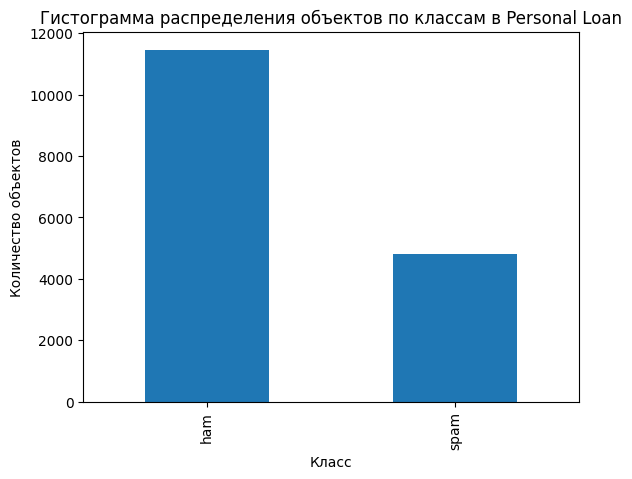

Доля объектов класса 0: 0.7045705860670844
Доля объектов класса 1: 0.2954294139329156


In [ ]:
# Построение гистограммы распределения объектов по классам
import matplotlib.pyplot as plt # visualization
train_data['text_type'].value_counts().plot(kind='bar')
plt.xlabel('Класс')
plt.ylabel('Количество объектов')
plt.title('Гистограмма распределения объектов по классам в Personal Loan')
plt.show()

# Вычисление доли объектов класса 0
fraction_class_0 = train_data['text_type'].value_counts(normalize=True)[0]
fraction_class_1 = train_data['text_type'].value_counts(normalize=True)[1]
print("Доля объектов класса 0:", fraction_class_0)
print("Доля объектов класса 1:", fraction_class_1)

##### Удаление лишних символов

In [ ]:
import re
import nltk
#import pymorphy2
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
stop_words_en = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
#morph = pymorphy2.MorphAnalyzer() more suitabe for russian

def clean_text(text):
    # Удаление HTML-тегов
    text = re.sub(r"<.*?>", " ", text)

    # Удаление лишних пробелов
    text = re.sub(r" +", " ", text)

    # Удаление всех символов, которые не являются буквами, цифрами или пробелами
    text = re.sub(r"[^\w\s]", " ", text)

    text = re.sub(r'(:\w+:)', '', text)  # Удаление эмодзи

    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    # Токенизация текста
    tokens = WhitespaceTokenizer().tokenize(text)

    # Приведение к нижнему регистру и удаление стоп-слов
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words_en]

    # Лемматизация токенов
    #tokens = [morph.parse(token)[0].normal_form for token in tokens] #for russian
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train_data['cleaned'] = train_data['text'].apply(lambda x: clean_text(x))

In [ ]:
test_data['cleaned'] = test_data['text'].apply(lambda x: clean_text(x))

#### Визуализируем наши данные после базовой обработки

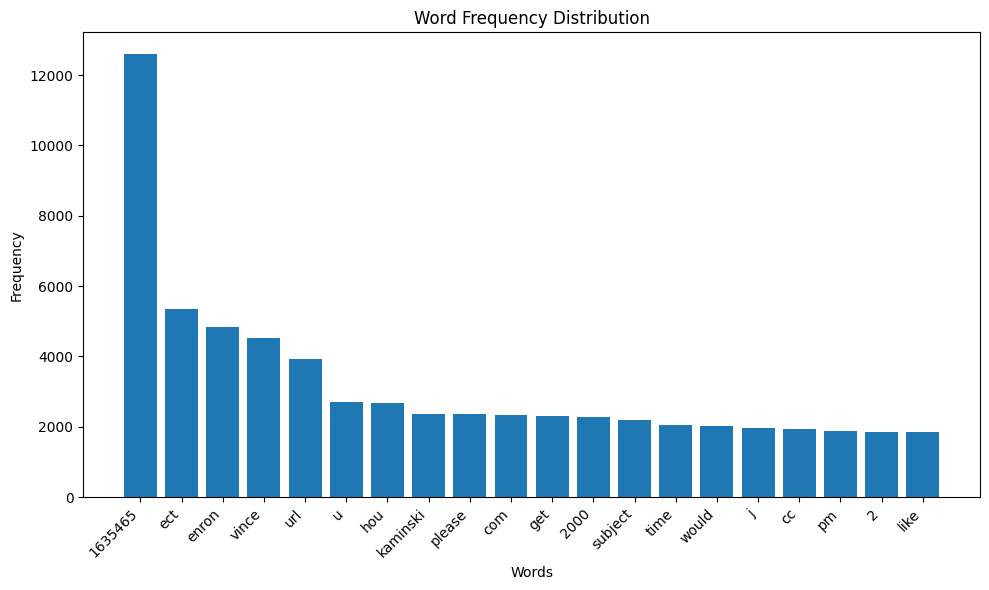

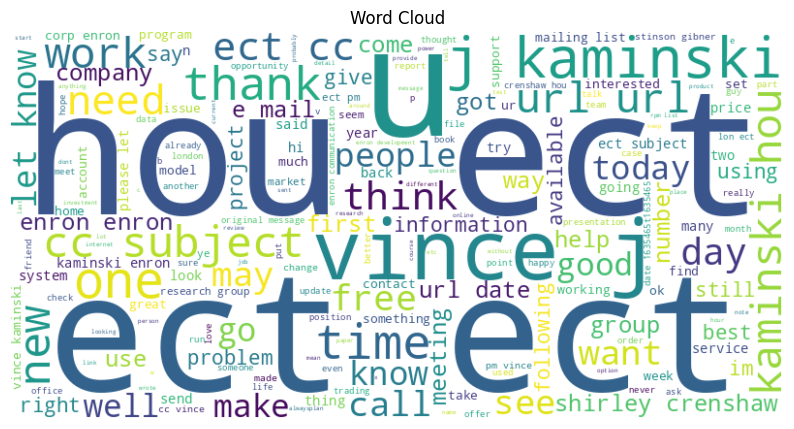

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming train_data is a pandas DataFrame with a column named 'cleaned'

# Word Frequency Distribution
def plot_word_frequency(text_column):
    # Initialize an empty list to store all tokens
    all_tokens = []
    # Iterate over each list of tokens in the text_column
    for tokens in text_column:
        # Join the tokens into a single string and append it to the all_tokens list
        all_tokens.extend(tokens)
    # Count the frequency of each word
    word_counts = Counter(all_tokens)
    # Sort the words by frequency
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    # Extract the top 20 most frequent words
    top_words = dict(sorted_word_counts[:20])

    # Plotting the word frequency distribution
    plt.figure(figsize=(10, 6))
    plt.bar(top_words.keys(), top_words.values())
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Word Frequency Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Word Cloud
def plot_word_cloud(text_column):
    # Initialize an empty list to store all tokens
    all_tokens = []
    # Iterate over each list of tokens in the text_column
    for tokens in text_column:
        # Join the tokens into a single string and append it to the all_tokens list
        all_tokens.extend(tokens)
    # Join all tokens into a single string
    combined_text = ' '.join(all_tokens)
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud')
    plt.show()

# Plotting Word Frequency Distribution
plot_word_frequency(train_data['cleaned'])

# Plotting Word Cloud
plot_word_cloud(train_data['cleaned'])


Мы можем заметить, что после базовой обработки есть вещи, которые необходимо удалить: числа, ect, url, words less than 2 charachters except for i.
Также можно заметить, что часто встречается слово enron и имя vince kaminski.
Поиск в интернете показал, что Корпорация «Энрон» — американская энергетическая компания, обанкротившаяся в 2001 году. А vince kaminski  worked as the Managing Director for Research at the failed energy trading corporation Enron until 2002

Перед тем как принимать решение для чисел, ect, url давайте построим графики, которые покажут распределение данных слов в зависимости от класса.


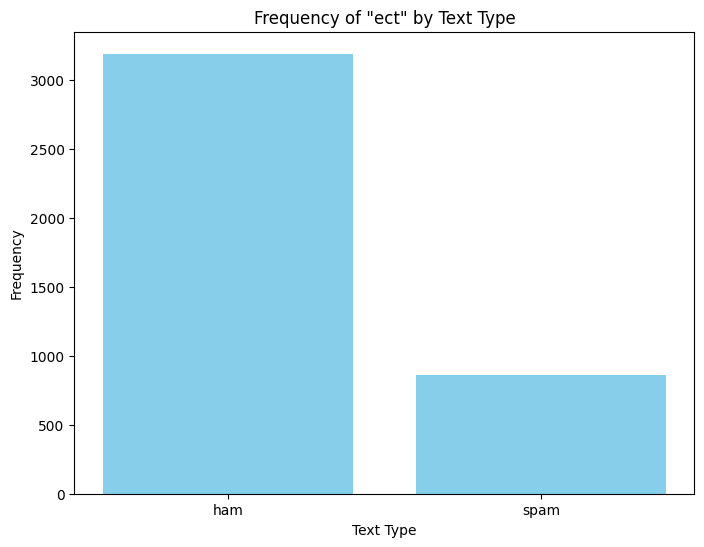

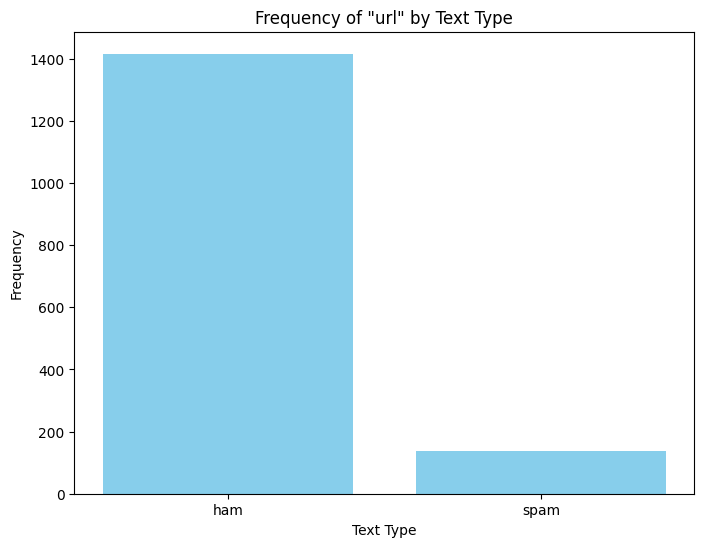

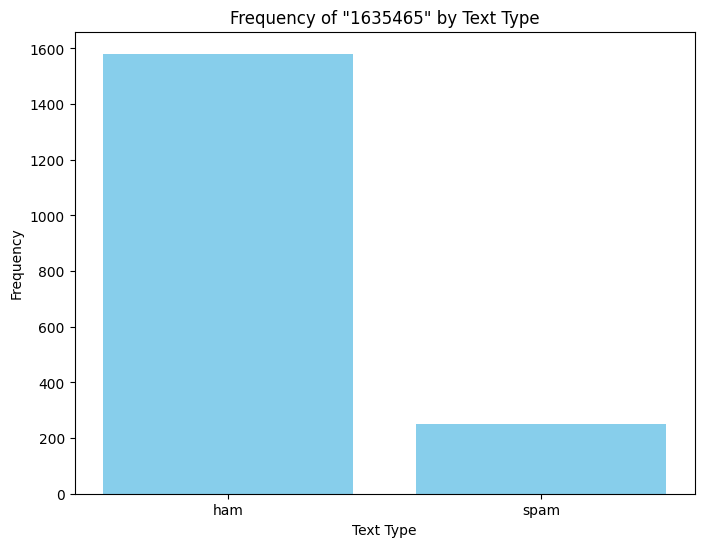

In [ ]:
# Выбор слов для визуализации
words_to_plot = ['ect', 'url', '1635465']

# Построение графиков
for word in words_to_plot:
    # Подсчет частоты встречаемости слова в зависимости от типа текста
    word_freq_by_type = train_data[train_data['text'].str.contains(word, case=False)]['text_type'].value_counts()

    # Построение графика
    plt.figure(figsize=(8, 6))
    plt.bar(word_freq_by_type.index, word_freq_by_type.values, color='skyblue')
    plt.title(f'Frequency of "{word}" by Text Type')
    plt.xlabel('Text Type')
    plt.ylabel('Frequency')
    plt.show()

Учитывая частоту встречаемости этих слов в наших классах, мы можем предположить, что они имеют значение для классификации. Поэтому пока что оставим их

### Topic modelling

Давайте проведем тематическое моделирование для того, чтобы бы выяснить, существуют ли темы в письмах и как они сооотносятся с классами.
Эта информация (если выяснится, что есть темы присущие определнному классу) может быть использована дальше при классификации

In [ ]:
!pip install pyLDAvis

In [ ]:
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
data = train_data.cleaned.values.tolist()

In [ ]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['make', 'sure', 'alex', 'know', 'birthday', 'fifteen', 'minute', 'far', 'youre', 'concerned']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


Найдем оптимальное количество тем в соответствии с Coherence score и Perplexity score

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

2
4
6
8


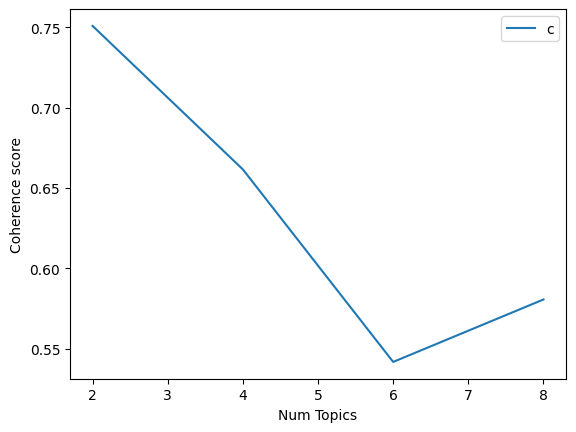

In [ ]:
# Evaluete optimal num_topics. Long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=2, limit=10, step=2)

# Show graph
limit=10; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Оптимальное количество тем обычно определяется там, где показатель согласованности самый высокий или начинает снижаться. В нашем случае график оценки согласованности имеет тенденцию к снижению, мы должны выбрать количество тем, где оценка согласованности самая высокая, прежде чем она начнет уменьшаться - 2

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, #2 топика
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"url" + 0.006*"get" + 0.004*"one" + 0.004*"free" + 0.004*"time" + '
  '0.004*"message" + 0.004*"like" + 0.003*"new" + 0.003*"list" + 0.003*"day"'),
 (1,
  '0.025*"enron" + 0.020*"vince" + 0.019*"ect" + 0.010*"subject" + '
  '0.010*"kaminski" + 0.009*"hou" + 0.009*"please" + 0.009*"cc" + 0.009*"com" '
  '+ 0.009*"pm"')]



Based on the keywords extracted from the two topics of the LDA model trained on the spam/ham dataset, we can draw the following conclusions:

Topic 0 (Potentially Spam):
Keywords like "url," "get," "free," "message," and "new" are commonly associated with spam messages.
These words suggest the presence of typical spam characteristics such as offers ("free"), solicitations ("get"), and links ("url").
Topic 1 (Potentially Ham):
j


Основываясь на ключевых словах, мы можем сделать следующие выводы:

**Тема 0 (Возможно spam)**:
- Ключевые слова, такие как "url", "get", "free", "message" и "new", часто ассоциируются со спам-сообщениями.
- Эти слова указывают на наличие типичных характеристик спама, таких как предложения ("free"), просьбы ("get") и ссылки ("url").

**Тема 1 (Возможно ham)**:
- Ключевые слова, такие как "enron", "vince", "ect", "kaminski", "hou" и "please", характерны для легитимных электронных писем.
- Эти слова ассоциируются с конкретными именами (например, "vince", "kaminski"), названиями компаний ("enron") и общепринятыми приветствиями в электронных письмах ("please").

Наличие конкретных имен и терминов, связанных с компанией, в Теме 1 соответствует описанию легитимных электронных писем, полученных из электронной почты управляющего директора Энрон Винсента Камински.
Напротив, встреча терминов, таких как "url" и "free" в Теме 0, указывает на содержание, характерное для спам-сообщений.

In [ ]:
import pyLDAvis.gensim_models
import gensim

# Disable multiprocessing in pyLDAvis
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.165448  0.0       1        1  58.753042
1     -0.165448  0.0       2        1  41.246958, topic_info=         Term         Freq        Total Category  logprob  loglift
95      enron  5166.000000  5166.000000  Default  30.0000  30.0000
47      vince  4085.000000  4085.000000  Default  29.0000  29.0000
16        ect  3950.000000  3950.000000  Default  28.0000  28.0000
42    subject  2039.000000  2039.000000  Default  27.0000  27.0000
26   kaminski  1961.000000  1961.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
439      week   571.599396   925.718053   Topic2  -5.8878   0.4035
32        new   631.308891  1640.713068   Topic2  -5.7884  -0.0695
28       like   631.848694  1680.714632   Topic2  -5.7876  -0.0927
194      need   575.591006  1244.992869   Topic2  -5.8808   0.1141
309       day   565.212407  1547.088550   Topic2  -5.8990  -0.1213

[150 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1003      1  0.999103  account
1003      2  0.001685  account
6404      1  0.999164    adobe
693       1  0.002888    april
693       2  0.999383    april
...     ...       ...      ...
296       2  0.011783    world
297       1  0.309455    would
297       2  0.690508    would
298       1  0.929592    wrote
298       2  0.071321    wrote

[193 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

### Подзадача 2: обучить модель по тексту сообщения определять, является ли ее содержимое СПАМом (ожидается, что будут опробованы несколько подходов, из которых аргументированно выбирается наилучший; можно использовать любую библиотеку или фреймворк)

#### Векторизация

In [ ]:
X = train_data['cleaned']
y = train_data['text_type']

X_test = test_data['cleaned']

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'text_type' column
y = label_encoder.fit_transform(y)

#ham: 0
#spam: 1

In [ ]:
#X = train_data['cleaned'].tolist()
#y = train_data['text_type'].tolist()

#X_test = test_data['cleaned'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


##### TF-IDF


In [ ]:
X_train_text = [' '.join(tokens) for tokens in X_train]
X_test_text = [' '.join(tokens) for tokens in X_test]
X_val_text = [' '.join(tokens) for tokens in X_val]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Создание объекта TfidfVectorizer с использованием биграмм
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

#Применение TF-IDF к текстовым данным тренировочной выборки
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train_text)

#Применение TF-IDF к текстовым данным тестовой выборки
tfidf_test_vectors = tfidf_vectorizer.transform(X_test_text)

#Применение TF-IDF к текстовым данным валидационной выборки
tfidf_val_vectors = tfidf_vectorizer.transform(X_val_text)

##### word2vec

In [ ]:
# Train the word2vec model
import gensim
from gensim.models import Word2Vec
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

In [ ]:
import numpy as np

w2v_model.wv.index_to_key
words = set(w2v_model.wv.index_to_key)
X_train_vect = [np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train]
X_val_vect = [np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_val]
X_test_vect = [np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test]

In [ ]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

X_val_vect_avg = []
for v in X_val_vect:
    if v.size:
        X_val_vect_avg.append(v.mean(axis=0))
    else:
        X_val_vect_avg.append(np.zeros(100, dtype=float))

##### BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_bow = CountVectorizer(max_features=100, ngram_range=(1, 1))
vectorizer_bow.fit(X_train_text)

X_train_bow = vectorizer_bow.transform(X_train_text)
X_test_bow = vectorizer_bow.transform(X_test_text)
X_val_bow = vectorizer_bow.transform(X_val_text)

#### Классификация

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

##### TF-IDF

###### Random Forest

In [ ]:
rf = RandomForestClassifier()
rf_model = rf.fit(tfidf_train_vectors, y_train)

y_pred = rf_model.predict_proba(tfidf_val_vectors)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC Score on Validation Set:", roc_auc)

ROC-AUC Score on Validation Set: 0.9524824771119453


In [ ]:
# You can set it to 'balanced' or specify custom class weights
class_weights = {0: 0.7, 1: 0.3}

rf = RandomForestClassifier(class_weight=class_weights)

rf_model = rf.fit(tfidf_train_vectors, y_train)

y_pred = rf_model.predict_proba(tfidf_val_vectors)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC Score on Validation Set:", roc_auc)

ROC-AUC Score on Validation Set: 0.9683269380305125


###### XGBoost

In [ ]:
from xgboost import XGBClassifier
# Define the XGBoost classifier
xgb_classifier = XGBClassifier()

# Train the XGBoost model
xgb_classifier.fit(tfidf_train_vectors, y_train)
# Make predictions on the testing set
y_pred_xgb = xgb_classifier.predict_proba(tfidf_val_vectors)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc_xgb = roc_auc_score(y_val, y_pred_xgb)
print("ROC-AUC Score on Validation Set:", roc_auc_xgb)

ROC-AUC Score on Validation Set: 0.9639851859773394


In [ ]:
from xgboost import XGBClassifier
# Define the XGBoost classifier
xgb_classifier = XGBClassifier(scale_pos_weight=70/30)

# Train the XGBoost model
xgb_classifier.fit(tfidf_train_vectors, y_train)
# Make predictions on the testing set
y_pred_xgb = xgb_classifier.predict_proba(tfidf_val_vectors)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc_xgb = roc_auc_score(y_val, y_pred_xgb)
print("ROC-AUC Score on Validation Set:", roc_auc_xgb)

ROC-AUC Score on Validation Set: 0.9624465522460292


#####Word2Vec

###### Random Forest

In [ ]:
rf = RandomForestClassifier()

#rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())
rf_model_w2v = rf.fit(X_train_vect_avg, y_train)

y_pred_w2v = rf_model_w2v.predict_proba(X_val_vect_avg)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc_w2v = roc_auc_score(y_val, y_pred_w2v)
print("ROC-AUC Score on Validation Set:", roc_auc_w2v)

ROC-AUC Score on Validation Set: 0.9601405274901351


In [ ]:
class_weights = {0: 0.7, 1: 0.3}

rf = RandomForestClassifier(class_weight=class_weights)

#rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())
rf_model_w2v = rf.fit(X_train_vect_avg, y_train)

y_pred_w2v = rf_model_w2v.predict_proba(X_val_vect_avg)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc_w2v = roc_auc_score(y_val, y_pred_w2v)
print("ROC-AUC Score on Validation Set:", roc_auc_w2v)

ROC-AUC Score on Validation Set: 0.9586469810968504


###### XGBoost

In [ ]:
from xgboost import XGBClassifier
# Define the XGBoost classifier
xgb_classifier = XGBClassifier()

# Train the XGBoost model
xgb_classifier.fit(X_train_vect_avg, y_train)

# Make predictions on the testing set
y_pred_xgb = xgb_classifier.predict_proba(X_val_vect_avg)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc_xgb = roc_auc_score(y_val, y_pred_xgb)
print("ROC-AUC Score on Validation Set:", roc_auc_xgb)

ROC-AUC Score on Validation Set: 0.9588173613892883


In [ ]:
from xgboost import XGBClassifier
# Define the XGBoost classifier
xgb_classifier = XGBClassifier(scale_pos_weight=70/30)

# Train the XGBoost model
xgb_classifier.fit(X_train_vect_avg, y_train)

# Make predictions on the testing set
y_pred_xgb = xgb_classifier.predict_proba(X_val_vect_avg)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc_xgb = roc_auc_score(y_val, y_pred_xgb)
print("ROC-AUC Score on Validation Set:", roc_auc_xgb)

ROC-AUC Score on Validation Set: 0.9581820604052513


#####BoW

###### Random Forest

In [ ]:
rf = RandomForestClassifier()

rf_model_bow = rf.fit(X_train_bow, y_train)

# Use the trained model to make predictions on the test data
y_pred_bow = rf_model_bow.predict_proba(X_val_bow)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc_bow = roc_auc_score(y_val, y_pred_bow)
print("ROC-AUC Score on Validation Set:", roc_auc_bow)

ROC-AUC Score on Validation Set: 0.888843398760574


In [ ]:
rf = RandomForestClassifier(class_weight=class_weights)

rf_model_bow = rf.fit(X_train_bow, y_train)

# Use the trained model to make predictions on the test data
y_pred_bow = rf_model_bow.predict_proba(X_val_bow)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc_bow = roc_auc_score(y_val, y_pred_bow)
print("ROC-AUC Score on Validation Set:", roc_auc_bow)

ROC-AUC Score on Validation Set: 0.875087455841597


###### XGBoost

In [ ]:
# Define the XGBoost classifier
xgb_classifier = XGBClassifier(scale_pos_weight=70/30)

# Train the XGBoost model
xgb_classifier.fit(X_train_bow, y_train)

# Make predictions on the testing set
y_pred_xgb = xgb_classifier.predict_proba(X_val_bow)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc_xgb = roc_auc_score(y_val, y_pred_xgb)
print("ROC-AUC Score on Validation Set:", roc_auc_xgb)

ROC-AUC Score on Validation Set: 0.9003243569503379


In [ ]:
# Define the XGBoost classifier
xgb_classifier = XGBClassifier()

# Train the XGBoost model
xgb_classifier.fit(X_train_bow, y_train)

# Make predictions on the testing set
y_pred_xgb = xgb_classifier.predict_proba(X_val_bow)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc_xgb = roc_auc_score(y_val, y_pred_xgb)
print("ROC-AUC Score on Validation Set:", roc_auc_xgb)

ROC-AUC Score on Validation Set: 0.9007367135091634


### Выводы:

***TF-IDF*** показал результаты, которые лучше других методов векторизации.
Word2Vec показал результаты чуть хуже TF-IDF. Причиной тому служит факт, что использовалась предобученная модель word2vec.

- **Представление данных**: TF-IDF, возможно, эффективно отразил важность слов в текстовых данных для классификации. Он присваивает веса словам на основе их частоты в документе и обратной частоты в документах, что отразилось на эффективности классификации классов.
- **Качество word embeddings**: pre-trained Word2Vec embeddings, возможно, не очень хорошо подходят для нашей конкретной задачи классификации. Embeddings Word2Vec обучаются на больших текстовых массивах и могут не улавливать семантическое значение слов в текстовых данных, специфичных для нашей задачи, так эффективно, как TF-IDF, который напрямую учитывает частоту слов в наборе данных


Дальше будем пробовать другие модели, но уже применимо только выбранному методу векторизации текста

###### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoost classifier
ada_clf = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train the AdaBoost classifier
ada_clf.fit(tfidf_train_vectors, y_train)

# Make predictions on the testing set
y_pred_ada = ada_clf.predict_proba(tfidf_val_vectors)[:, 1]

# Calculate ROC-AUC score for the validation set
roc_auc_ada = roc_auc_score(y_val, y_pred_ada)
print("ROC-AUC Score on Validation Set:", roc_auc_ada)

ROC-AUC Score on Validation Set: 0.909675108345553


Учитывая характеристики нашего набора данных, включая дисбаланс классов и характеристики признаков (векторные представления word2vec), эти модели хорошо подходят для решения задачи классификации спама и официальных сообщений.

- **AdaBoost** последовательно обучает несколько слабых обучающихся, придавая больший вес неправильно классифицированным экземплярам на каждой итерации;
- **Случайный лес** хорошо справляется с несбалансированными данными, путем указания весов классов с помощью параметра class_weight мы смягчяем эффекты дисбаланса классов
- **XGBoost** - это эффективная реализация алгоритма стохастического градиентного бустинга. Хотя в целом алгоритм работает хорошо, даже на несбалансированных наборах данных классификации, он предлагает способ настроить алгоритм обучения таким образом, чтобы уделять больше внимания неправильной классификации второстепенного класса для наборов данных с асимметричным распределением по классам.

В целом, выбор в сторону анасамблевых алгоритмов пал из-за их способности улучшать результаты моделей внутри них, что кажется полезным, учитвая существующий дисбаланс классов.

Таким образом, мы получили следующие результаты по моделям:
- **RF**: **0.9525**
- **RF** (adjusting class imbalance): **0.9683**
- **XGBoost**: **0.9640**
- **XGBoost** (adjusting for class imbalance): **0.9624**
- **AdaBoost**: **0.9097**

Лучший результат у *RF с adjusting for class imbalance*, поэтому давайте обучим модель на полной тренировочной выборке и протестируем ее на тестовой.

###Применение модели к тестовой выборке

In [ ]:
#предобработка
X = train_data['cleaned']
y = train_data['text_type']

X_test = test_data['cleaned']

y = label_encoder.fit_transform(y)

#векторизация
X_text = [' '.join(tokens) for tokens in X]
X_test_text = [' '.join(tokens) for tokens in X_test]


from sklearn.feature_extraction.text import TfidfVectorizer
# Создание объекта TfidfVectorizer с использованием биграмм
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

#Применение TF-IDF к текстовым данным тренировочной выборки
tfidf_train_vectors_full = tfidf_vectorizer.fit_transform(X_text)

#Применение TF-IDF к текстовым данным тестовой выборки
tfidf_test_vectors = tfidf_vectorizer.transform(X_test_text)

In [ ]:
from xgboost import XGBClassifier
# Define the XGBoost classifier
xgb_classifier = XGBClassifier(scale_pos_weight=70/30)

# Train the XGBoost model
xgb_classifier.fit(tfidf_train_vectors_full, y)

# Make predictions on the testing set
y_pred_xgb = xgb_classifier.predict_proba(tfidf_test_vectors)[:, 1]


In [ ]:
#Создание DataFrame с результатами
results = pd.DataFrame({"score": y_pred_xgb, "text": test_data["text"]})

#Сохранение результатов в CSV файл
results.to_csv("test_spam_score_proba.csv", index=False)

In [ ]:
# Make predictions on the testing set
y_pred_xgb = xgb_classifier.predict(tfidf_test_vectors)
#Создание DataFrame с результатами
results_binary = pd.DataFrame({"score": y_pred_xgb, "text": test_data["text"]})

#Сохранение результатов в CSV файл
results_binary.to_csv("test_spam_score_binary.csv", index=False)

In [ ]:
results

,score,text
0,0.213035,j jim whitehead ejw cse ucsc edu writes j you ...
1,0.513331,original message from bitbitch magnesium net p...
2,0.000493,java for managers vince durasoft who just taug...
3,0.154785,there is a youtuber name saiman says
4,0.698860,underpriced issue with high return on equity t...
...,...,...
4065,0.223460,husband to wifetum meri zindagi hoorwifeor kya...
4066,0.000132,baylor enron case study cindy yes i shall co a...
4067,0.300687,boring as compared to tp
4068,0.022246,hellogorgeous hows u my fone was on charge lst...


In [ ]:
results_binary

,score,text
0,0,j jim whitehead ejw cse ucsc edu writes j you ...
1,1,original message from bitbitch magnesium net p...
2,0,java for managers vince durasoft who just taug...
3,0,there is a youtuber name saiman says
4,1,underpriced issue with high return on equity t...
...,...,...
4065,0,husband to wifetum meri zindagi hoorwifeor kya...
4066,0,baylor enron case study cindy yes i shall co a...
4067,0,boring as compared to tp
4068,0,hellogorgeous hows u my fone was on charge lst...
